In [1]:
#fastai study group.  learning to do a competition in Kaggle.
#my code compilation

#11/22/2020 Compile clean draft, based on fastai-2020 study course
#     make it work like 09-tabular
#     no bells no whistles
#.    simple: merge features & targets, get lr min recommendation, learn and relearn.
#     expect a score ~.02025

#next: params grid, cross-validation
#next: incorporate non-scored

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv


In [3]:
from fastai.tabular.all import *

## 0. Load Data

In [4]:
path = Path('../input/lish-moa')
path.ls()

(#6) [Path('../input/lish-moa/test_features.csv'),Path('../input/lish-moa/sample_submission.csv'),Path('../input/lish-moa/train_drug.csv'),Path('../input/lish-moa/train_features.csv'),Path('../input/lish-moa/train_targets_scored.csv'),Path('../input/lish-moa/train_targets_nonscored.csv')]

In [5]:
train_drug = pd.read_csv(path/'train_drug.csv')

print('train drug data\n', train_drug.shape)
display(train_drug.head(3))
train_drug.describe()

train drug data
 (23814, 2)


,sig_id,drug_id
0,id_000644bb2,b68db1d53
1,id_000779bfc,df89a8e5a
2,id_000a6266a,18bb41b2c


,sig_id,drug_id
count,23814,23814
unique,23814,3289
top,id_ba25e4bf7,cacb2b860
freq,1,1866


In [6]:
train_features = pd.read_csv(path/'train_features.csv')
train_targets_scored = pd.read_csv(path/'train_targets_scored.csv')
train_targets_nonscored = pd.read_csv(path/'train_targets_nonscored.csv')
test_features = pd.read_csv(path/'test_features.csv')


In [7]:
print('train features', train_features.shape)
print('train targets', train_targets_scored.shape)
print('test features', test_features.shape)

display(train_features.head(3))
display(train_targets_scored.head(3))

train features (23814, 876)
train targets (23814, 207)
test features (3982, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 0.1 EDA

In [8]:
train_features.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


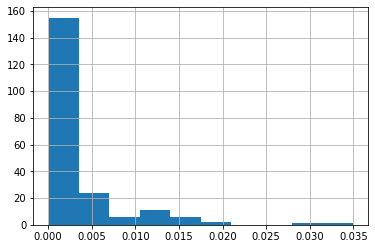

In [9]:
train_targets_scored.iloc[1:].mean().hist()

In [10]:
sub = pd.read_csv(path/'sample_submission.csv')

## 1. Data Prep
use TabularPandas and TabularProc

In [11]:
cat_names = L(list(train_features.columns[1:4]))#$ac
cont_names = L(list(train_features.columns[4:]))
cat_names, cont_names

((#3) ['cp_type','cp_time','cp_dose'],
 (#872) ['g-0','g-1','g-2','g-3','g-4','g-5','g-6','g-7','g-8','g-9'...])

In [12]:
#$ac scored_cols = list(train_targets_scored.columns[1:])
#$ac y_names = scored_cols
dep_var = list(train_targets_scored.columns[1:])


In [13]:
print(train_features.shape)
train_features[dep_var] = train_targets_scored[dep_var]
print(train_features.shape)

(23814, 876)
(23814, 1082)


In [14]:
##error: NameError: name 'RandomSplitter' is not defined
#splits = RandomSplitter(valid_pct=0.2)(range_of(train_features))
#splits

#temp split manually
#define train vs valid split
n_train = int(train_features.shape[0] *.8)
split_idx = np.random.RandomState(seed=24).permutation(train_features.shape[0])
train_idx, valid_idx = split_idx[:n_train], split_idx[n_train:]
splits = (list(train_idx), list(valid_idx))

#preview
len(splits[0]), len(splits[1])

(19051, 4763)

TabularPandas needs to be told which columns are continuous and which are categorical. We can handle that automatically using the helper function cont_cat_split:

In [15]:
#cont,cat = cont_cat_split(train_features, 1, dep_var=dep_var)
#$acmycheck doesn't work
#cat

In [16]:
procs = [Categorify, Normalize] #$ac FillMissing, 

data = TabularPandas(train_features, procs=procs, cat_names=cat_names,
                    cont_names=cont_names, y_names=dep_var, splits = splits) #class fastai.tabular.core.TabularPandas
len(data.train),len(data.valid)

(19051, 4763)

In [17]:
data.show(5)

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,g-246,g-247,g-248,g-249,g-250,g-251,g-252,g-253,g-254,g-255,g-256,g-257,g-258,g-259,g-260,g-261,g-262,g-263,g-264,g-265,g-266,g-267,g-268,g-269,g-270,g-271,g-272,g-273,g-274,g-275,g-276,g-277,g-278,g-279,g-280,g-281,g-282,g-283,g-284,g-285,g-286,g-287,g-288,g-289,g-290,g-291,g-292,g-293,g-294,g-295,g-296,g-297,g-298,g-299,g-300,g-301,g-302,g-303,g-304,g-305,g-306,g-307,g-308,g-309,g-310,g-311,g-312,g-313,g-314,g-315,g-316,g-317,g-318,g-319,g-320,g-321,g-322,g-323,g-324,g-325,g-326,g-327,g-328,g-329,g-330,g-331,g-332,g-333,g-334,g-335,g-336,g-337,g-338,g-339,g-340,g-341,g-342,g-343,g-344,g-345,g-346,g-347,g-348,g-349,g-350,g-351,g-352,g-353,g-354,g-355,g-356,g-357,g-358,g-359,g-360,g-361,g-362,g-363,g-364,g-365,g-366,g-367,g-368,g-369,g-370,g-371,g-372,g-373,g-374,g-375,g-376,g-377,g-378,g-379,g-380,g-381,g-382,g-383,g-384,g-385,g-386,g-387,g-388,g-389,g-390,g-391,g-392,g-393,g-394,g-395,g-396,g-397,g-398,g-399,g-400,g-401,g-402,g-403,g-404,g-405,g-406,g-407,g-408,g-409,g-410,g-411,g-412,g-413,g-414,g-415,g-416,g-417,g-418,g-419,g-420,g-421,g-422,g-423,g-424,g-425,g-426,g-427,g-428,g-429,g-430,g-431,g-432,g-433,g-434,g-435,g-436,g-437,g-438,g-439,g-440,g-441,g-442,g-443,g-444,g-445,g-446,g-447,g-448,g-449,g-450,g-451,g-452,g-453,g-454,g-455,g-456,g-457,g-458,g-459,g-460,g-461,g-462,g-463,g-464,g-465,g-466,g-467,g-468,g-469,g-470,g-471,g-472,g-473,g-474,g-475,g-476,g-477,g-478,g-479,g-480,g-481,g-482,g-483,g-484,g-485,g-486,g-487,g-488,g-489,g-490,g-491,g-492,g-493,g-494,g-495,g-496,g-497,g-498,g-499,g-500,g-501,g-502,g-503,g-504,g-505,g-506,g-507,g-508,g-509,g-510,g-511,g-512,g-513,g-514,g-515,g-516,g-517,g-518,g-519,g-520,g-521,g-522,g-523,g-524,g-525,g-526,g-527,g-528,g-529,g-530,g-531,g-532,g-533,g-534,g-535,g-536,g-537,g-538,g-539,g-540,g-541,g-542,g-543,g-544,g-545,g-546,g-547,g-548,g-549,g-550,g-551,g-552,g-553,g-554,g-555,g-556,g-557,g-558,g-559,g-560,g-561,g-562,g-563,g-564,g-565,g-566,g-567,g-568,g-569,g-570,g-571,g-572,g-573,g-574,g-575,g-576,g-577,g-578,g-579,g-580,g-581,g-582,g-583,g-584,g-585,g-586,g-587,g-588,g-589,g-590,g-591,g-592,g-593,g-594,g-595,g-596,g-597,g-598,g-599,g-600,g-601,g-602,g-603,g-604,g-605,g-606,g-607,g-608,g-609,g-610,g-611,g-612,g-613,g-614,g-615,g-616,g-617,g-618,g-619,g-620,g-621,g-622,g-623,g-624,g-625,g-626,g-627,g-628,g-629,g-630,g-631,g-632,g-633,g-634,g-635,g-636,g-637,g-638,g-639,g-640,g-641,g-642,g-643,g-644,g-645,g-646,g-647,g-648,g-649,g-650,g-651,g-652,g-653,g-654,g-655,g-656,g-657,g-658,g-659,g-660,g-661,g-662,g-663,g-664,g-665,g-666,g-667,g-668,g-669,g-670,g-671,g-672,g-673,g-674,g-675,g-676,g-677,g-678,g-679,g-680

In [18]:
#data loaders
dls = data.dataloaders(512) #$achyperparam 1024

## 2. Model

In [19]:
#setup learner
learn = tabular_learner(dls, layers=[600,300], loss_func=BCEWithLogitsLossFlat()) #$achyperparam layers=[500,250], loss?

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.0020892962347716093)

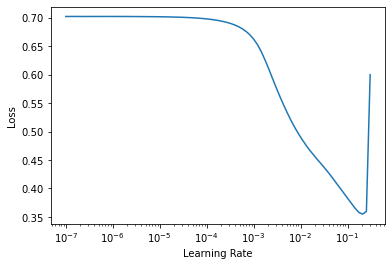

In [20]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(8, 2e-3)

epoch,train_loss,valid_loss,time
0,0.431003,0.031635,00:00
1,0.156311,0.020277,00:00
2,0.075360,0.018465,00:01
3,0.043493,0.017837,00:00
4,0.029367,0.017408,00:00
5,0.022722,0.017182,00:01
6,0.019492,0.017077,00:00
7,0.017917,0.017059,00:01


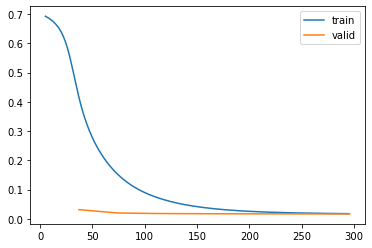

In [22]:
learn.recorder.plot_loss()

In [23]:
learn.unfreeze()
learn.fit_one_cycle(5,slice(1e-4),wd=0.2)

epoch,train_loss,valid_loss,time
0,0.016546,0.017041,00:01
1,0.016495,0.016993,00:00
2,0.016473,0.016964,00:00
3,0.016429,0.016949,00:01
4,0.016387,0.016932,00:00


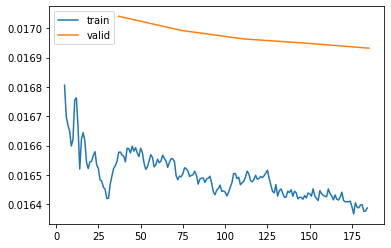

In [24]:
learn.recorder.plot_loss()

In [25]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5),wd=0.25)

epoch,train_loss,valid_loss,time
0,0.016350,0.016935,00:00
1,0.016364,0.016928,00:00
2,0.016367,0.016925,00:00
3,0.016341,0.016927,00:00
4,0.016335,0.016922,00:01


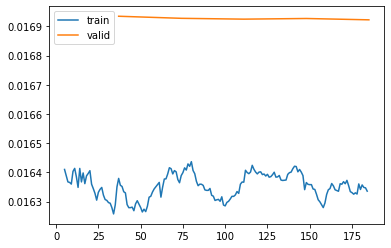

In [26]:
learn.recorder.plot_loss()

In [27]:
#learn.unfreeze()
#learn.fit_one_cycle(5, slice(1e-6),wd=0.4)

In [28]:
#learn.recorder.plot_loss()

## 3. Predict

In [29]:
#Get Predictions for Submission
#We follow the guide to setting up a test set here: https://forums.fast.ai/t/a-brief-guide-to-test-sets-in-v2-you-can-do-labelled-now-too/57054
#testset
test_dl = dls.test_dl(test_features)

In [30]:
preds,_ = learn.get_preds(dl=test_dl)

In [31]:
preds_df = pd.DataFrame(preds).astype("float")
preds_df.head

<bound method NDFrame.head of            0         1         2         3         4         5         6    \
0     0.002442  0.001532  0.001752  0.014261  0.020715  0.005374  0.002446   
1     0.000316  0.000513  0.001500  0.012126  0.006391  0.002464  0.002026   
2     0.000013  0.000012  0.000039  0.001345  0.001863  0.000256  0.000089   
3     0.000500  0.000996  0.002624  0.027676  0.008393  0.005980  0.004302   
4     0.001088  0.000728  0.001033  0.014927  0.017260  0.004432  0.002104   
...        ...       ...       ...       ...       ...       ...       ...   
3977  0.000133  0.000302  0.000364  0.003727  0.003641  0.001004  0.000551   
3978  0.001439  0.000498  0.000600  0.006970  0.016961  0.003112  0.001704   
3979  0.000557  0.000196  0.000484  0.005468  0.016093  0.003218  0.001186   
3980  0.000320  0.002317  0.001353  0.013736  0.019503  0.002735  0.004594   
3981  0.001215  0.000562  0.000973  0.012141  0.017417  0.004230  0.002195   

           7         8         9 

In [32]:
submission = sub
submission[dep_var] = preds_df
submission.loc[test_features['cp_type']=='ctl_vehicle', dep_var] = 0

submission.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.002442,0.001532,0.001752,0.014261,0.020715,0.005374,0.002446,0.008698,0.000910,...,0.000342,0.000779,0.003434,0.004501,0.004209,0.000496,0.006532,0.001625,0.001928,0.002069
1,id_001897cda,0.000316,0.000513,0.001500,0.012126,0.006391,0.002464,0.002026,0.004997,0.000632,...,0.000362,0.001060,0.002362,0.006622,0.010163,0.001322,0.027555,0.000425,0.002764,0.000747
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000500,0.000996,0.002624,0.027676,0.008393,0.005980,0.004302,0.008135,0.001410,...,0.000741,0.002299,0.007299,0.031866,0.006529,0.001944,0.018324,0.001388,0.007884,0.001717
4,id_0027f1083,0.001088,0.000728,0.001033,0.014927,0.017260,0.004432,0.002104,0.004751,0.000503,...,0.000356,0.000717,0.002183,0.001354,0.001433,0.000363,0.002029,0.002347,0.002126,0.002018


In [33]:
submission.to_csv('submission.csv', index=False)